In [1]:
import requests                # Include HTTP Requests module
from bs4 import BeautifulSoup  # Include BS web scraping module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#import random
#from sqlalchemy import create_engine
#from sqlalchemy import Table, Column, Integer, String, MetaData, ForeignKey, select
#from sqlalchemy.sql import and_, or_, not_

In [2]:
url = "https://meangreensports.com/sports/mens-basketball/stats/2020-21/loyola-university-chicago/boxscore/4822"
r = requests.get(url,verify=False)
soup = BeautifulSoup(r.text, "html.parser")
prds = soup.find_all('section', attrs = {'id':'play-by-play'})


C:\Users\scohendevries\AppData\Local\Continuum\miniconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [3]:
dfRaw = pd.DataFrame()
for i in prds:
    p = 1
    T = '00:20:00'
    team = ''
    action = ''
    plr = ''
    for prd in i.find_all('div',id=re.compile(r'period')):
        for pos in prd.find_all('tr')[1:]:
            t = pos.find('th',attrs={'scope':'row'}).text
            if re.search(r'\d',t):
                T = t
            a = pos.find(lambda tag: tag.name == 'td' and 
                                   tag.get('class') == ['text-right','hide-on-medium-down']).text.strip()
            h = pos.find(lambda tag: tag.name == 'td' and 
                                   tag.get('class') == ['hide-on-medium-down']).text.strip()
            if len(a)>0:
                team = 'A'
                action = a
            else:
                team = 'H'
                action = h
            try:
                plr = action.split(' by ')[1]
            except:
                print(action)
            dfRaw = pd.concat([dfRaw,
                              pd.DataFrame([[p,T,team,action,plr]],
                                          columns=['Period','Time','Team','ActionRaw','Player'])
                              ])
        p += 1

dfRaw['Action'] = dfRaw.ActionRaw.str.extract('([^a-z]{2,})')

In [4]:
def cleanAction(x):
    x = re.sub('^\d+', '', x).lstrip()
    x = re.sub('\d+$', '', x).rstrip()
    x = re.sub(' by$', '', x).rstrip()
    return x
def cleanPeriod(x):
    x = int(''.join(filter(str.isdigit, x)))
    return x
def cleanPlayer(x):
    x = x.lstrip().rstrip()
    return x
def getStarters(df):
    nprd = df['Period'].max()

    periodStart = pd.to_timedelta('00:00:00')
    periodEnd = pd.to_timedelta('00:40:00')
    if nprd > 2:
        n = nprd - 2
        while n > 0:
            periodEnd += pd.to_timedelta('00:05:00')
            n -= 1
    lineups2 = df[df.Action.isin(['SUB IN','SUB OUT'])
                 ][['Player','Action','Time','Period','Team']]
    
    linePV = pd.pivot_table(lineups2,index=['Player','Team'],columns='Action',values='Time',aggfunc=np.min).reset_index()
    linePV['SUB IN'] = linePV['SUB IN'].fillna(periodStart)
    linePV['SUB OUT'] = linePV['SUB OUT'].fillna(periodEnd)
    
    starters = linePV[
        (
            (linePV['SUB OUT'] < linePV['SUB IN'])
        )
        |
        (
            (linePV['SUB IN'] == '00:00:00')
        )
                     ][['Team','Player','SUB OUT','SUB IN']]
    return list(starters[starters['Team']=='H']['Player']),list(starters[starters['Team']=='A']['Player'])

def getStartersByPeriod(df,p):
    periodStart = pd.to_timedelta('00:00:00')
    periodEnd = pd.to_timedelta('00:20:00')
    if p > 2:
        periodEnd = pd.to_timedelta('00:05:00')
    lineups2 = df[
        df.Action.isin(['SUB IN','SUB OUT'])
                 ][['Player','Action','Time','Period','Team']]
    lineups2 = lineups2[lineups2['Period']==p]
    linePV = pd.pivot_table(lineups2,index=['Player','Team'],columns='Action',values='Time',aggfunc=np.min).reset_index()
    linePV['SUB IN'] = linePV['SUB IN'].fillna(periodStart)
    linePV['SUB OUT'] = linePV['SUB OUT'].fillna(periodEnd)
    
    starters = linePV[
        (
            (linePV['SUB OUT'] < linePV['SUB IN'])
        )
        |
        (
            (linePV['SUB IN'] == '00:00:00')
        )
                     ][['Team','Player','SUB OUT','SUB IN']]
    return list(starters[starters['Team']=='H']['Player']),list(starters[starters['Team']=='A']['Player'])

def extractParens(s):
    pat = '\(([^)]+)'
    if re.search(pat,s):
        s = re.findall(pat, s)[0]
    else:
        s = ''
    return s
def removeParens(x):
    return x.split("(")[0]

In [5]:
try:
    dfRaw['Duration'] = pd.to_datetime(dfRaw['Time'].astype(str)).diff().dt.total_seconds().div(-60)
except:
    dfRaw['Duration'] = 0

In [6]:
actValMap = {
    'MISS LAYUP':0
    , 'REBOUND DEF':0
    , 'GOOD JUMPER':2
    , 'MISS 3PTR':0
    , 'REBOUND OFF':0
    , 'GOOD 3PTR':3
    , 'ASSIST':0
    , 'FOUL':0
    , 'GOOD LAYUP':2
    , 'BLOCK':0
    , 'TIMEOUT 30SEC':0
    , 'SUB OUT':0
    , 'SUB IN':0
    , 'TURNOVER':0
    , 'STEAL':0
    , 'MISS JUMPER':0
    , 'TIMEOUT MEDIA':0
    , 'REBOUND DEADB':0
    , 'GOOD FT':1
    , 'GOOD DUNK':2
    , 'MISS FT':0
}

In [7]:
dfRaw['Action'] = dfRaw['Action'].apply(cleanAction)
#dfRaw['Period'] = dfRaw['Period'].apply(cleanPeriod)#.apply(int)
#dfRaw['Duration'] = df['duration'].apply(int)
dfRaw['ActionValue'] = dfRaw['Action'].map(actValMap).map(int,na_action='ignore')
    
dfRaw['Time'] = pd.to_timedelta('00:'+dfRaw['Time'])
dfRaw.loc[dfRaw['Period'] <= 2,'Time'] = pd.to_timedelta('00:20:00') - dfRaw.loc[dfRaw['Period'] <= 2,'Time']
dfRaw.loc[dfRaw['Period'] > 2,'Time'] = pd.to_timedelta('00:05:00') - dfRaw.loc[dfRaw['Period'] > 2,'Time']
dfRaw.loc[dfRaw['Period'] == 2,'Time'] += pd.to_timedelta('00:20:00')
dfRaw.loc[dfRaw['Period'] == 3,'Time'] += pd.to_timedelta('00:25:00')
dfRaw.loc[dfRaw['Period'] == 4,'Time'] += pd.to_timedelta('00:30:00')
dfRaw.loc[dfRaw['Period'] == 5,'Time'] += pd.to_timedelta('00:35:00')
dfRaw.loc[dfRaw['Period'] == 6,'Time'] += pd.to_timedelta('00:40:00')
dfRaw.loc[dfRaw['Period'] == 7,'Time'] += pd.to_timedelta('00:45:00')
dfRaw.loc[dfRaw['Period'] == 8,'Time'] += pd.to_timedelta('00:50:00')

In [8]:
dfRaw['x'] = dfRaw['Player'].apply(extractParens)
dfRaw['Player'] = dfRaw['Player'].apply(removeParens)
dfRaw['Player'] = dfRaw['Player'].apply(cleanPlayer)
#dfRaw['Duration'] = dfRaw['Duration'].apply(int)
dfRaw.loc[dfRaw.Duration.isna(),'Duration'] = pd.to_timedelta(dfRaw.loc[dfRaw.Duration.isna(),'Time']).dt.total_seconds()#.div(-60)

In [9]:
dfRaw['seqNo'] = dfRaw['Time'].ne(dfRaw['Time'].shift()).cumsum()

In [10]:
conditions = [
    (dfRaw['ActionValue'] == 1),
    (dfRaw['ActionValue'] == 2),
    (dfRaw['ActionValue'] == 3),
    (dfRaw['Action'].str.contains('miss') & dfRaw['Action'].str.contains('3')),
    (dfRaw['Action'].str.contains('miss') & ~dfRaw['Action'].str.contains('3') & ~dfRaw['Action'].str.contains('ft')),
    (dfRaw['Action'].str.contains('miss') & ~dfRaw['Action'].str.contains('3') & dfRaw['Action'].str.contains('ft'))
]
choices = ['FTM', 'FG2', 'FG3','3PA','2PA','FTA']
dfRaw['action_edit1'] = np.select(conditions, choices, default=dfRaw['Action'])
    
dfRaw['playScore'] = dfRaw['Time'].map(dfRaw.groupby("Time")['ActionValue'].sum())

In [11]:
def set_pm(df,rosterH,rosterA,debug=False,isHome=True):
    HLU,ALU = getStarters(df)

    lineupDF = df[df.Action.isin(['SUB IN','SUB OUT'])].copy().reindex(columns=['Time'
                                                                                ,'Action'
                                                                                ,'Player'
                                                                                ,'Team'
                                                                                ,'scoreHome'
                                                                                ,'scoreAway'
                                                                                ,'seqNo'
                                                                                ,'Period'
                                                                               ])
    lineupDF = lineupDF.reset_index()
    
    #rosterH = [p for p in lineupDF[lineupDF['team']=='Home']['player'].unique()]
    #rosterA = [p for p in lineupDF[lineupDF['team']=='Away']['player'].unique()]
    
    seq = lineupDF.loc[0,'seqNo'].copy()
    time = lineupDF.loc[0,'Time']
    hSc = lineupDF.loc[0,'scoreHome'].copy()
    aSc = lineupDF.loc[0,'scoreAway'].copy()
    p = lineupDF.loc[0,'Period'].copy()
    diff = hSc-aSc
    
    away = pd.DataFrame(data={'Lineup':[ALU],'Time':pd.to_timedelta('00:00:00'),'Team':'A','diff':0}).head(1)
    home = pd.DataFrame(data={'Lineup':[HLU],'Time':pd.to_timedelta('00:00:00'),'Team':'H','diff':0}).head(1)
    
    h = home.loc[0,'Lineup'].copy()
    h.sort()
    a = away.loc[0,'Lineup'].copy()
    a.sort()
    
    hPlayerPM = {'H':{i:{'curDiff':0, 'pm':0, 'curTime':pd.to_timedelta('00:00:00'), 'tmp':0} for i in lineupDF[lineupDF['Team']=='H'].Player.unique()}}
    aPlayerPM = {'A':{i:{'curDiff':0, 'pm':0, 'curTime':pd.to_timedelta('00:00:00'), 'tmp':0} for i in lineupDF[lineupDF['Team']=='A'].Player.unique()}}
    aPlayerPM.update(hPlayerPM)
    playerPM = aPlayerPM
    if debug:
        print('Home On Floor: ' + str(h))
        print('Away On Floor: ' + str(a))
    try:
        stints = pd.DataFrame(data = {'seqStart':0
                                      , 'seqEnd':seq
                                      , 'timeStart':pd.to_timedelta('00:00:00')
                                      , 'timeEnd':time
                                      , 'diffStart':0
                                      , 'diffEnd': diff
                                      , 'HOF':[[p for p in h]]
                                      , 'AOF':[[p for p in a]]
                                      , 'HX':[[1 if p in h else 0 for p in rosterH]]
                                      , 'AX':[[-1 if p in a else 0 for p in rosterA]]
                                      , 'HR':[[i for i in rosterH]]
                                      , 'AR':[[i for i in rosterA]]
                                      , 'Y':pd.Series((diff)/(seq))
                                     })
    except:
        pd.DataFrame(data = {'seqStart':0
                                      , 'seqEnd':seq
                                      , 'timeStart':pd.to_timedelta('00:00:00')
                                      , 'timeEnd':time
                                      , 'diffStart':0
                                      , 'diffEnd': diff
                                      , 'HOF':[[p for p in h]]
                                      , 'AOF':[[p for p in a]]
                                      , 'HX':[[1 if p in h else 0 for p in rosterH]]
                                      , 'AX':[[-1 if p in a else 0 for p in rosterA]]
                                      , 'HR':[[i for i in rosterH]]
                                      , 'AR':[[i for i in rosterA]]
                            }
                    )
        return
    
    hx = [1 if p in h else 0 for p in rosterH]
    ax = [1 if p in a else 0 for p in rosterA]
    
    for i in range(0,len(lineupDF)):
        nseq = lineupDF.loc[i,'seqNo'].copy()
        ntime = lineupDF.loc[i,'Time']
        plyr = lineupDF.loc[i,'Player']
        act = lineupDF.loc[i,'Action']
        tm = lineupDF.loc[i,'Team']
        np = lineupDF.loc[i,'Period']
        ndiff = diff.copy()
        #print(seq)
        #print(nseq)
        if np != p:
            h,a = getStartersByPeriod(df,np)
        if nseq != seq:
            hSc = lineupDF.loc[i,'scoreHome'].copy()
            aSc = lineupDF.loc[i,'scoreAway'].copy()
            ndiff = hSc - aSc
            #if tm=="Away":
            #    ndiff *= -1
            if homeSub:
                try:
                    newH = pd.DataFrame(data={'lineup':[[p for p in h]],'time':time,'team':'H','diff':ndiff},index=[0])
                    home = home.append(newH)
                    if debug:
                        print('Added ' + str(newH.loc[0,'lineup']) + ' to Home lineups')
                except ValueError as e:
                    if debug:
                        print('Couldn''t add ' + str(newH))
                        print(e)
            if awaySub:
                try:
                    newA = pd.DataFrame(data={'lineup':[[p for p in a]],'time':time,'team':'A','diff':aSc-hSc},index=[0])#.head(1)
                    away = away.append(newA)
                    if debug:
                        print('Added ' + str(newA.loc[0,'lineup']) + ' to Away lineups')
                except ValueError as e:
                    if debug:
                        print('Couldn''t add ' + str(newA))
                        print(e)
            hx_cur = []
            ax_cur = []
            hx_cur = [1 if p in h else 0 for p in rosterH]
            ax_cur = [-1 if p in a else 0 for p in rosterA]
            newStint = pd.DataFrame(data={'seqStart':seq
                                          , 'seqEnd':nseq
                                          , 'timeStart':time
                                          , 'timeEnd':ntime
                                          , 'diffStart':diff
                                          , 'diffEnd': ndiff
                                          , 'HOF': [[p for p in h]]
                                          , 'AOF': [[p for p in a]]
                                          , 'HX':[hx_cur]
                                          , 'AX':[ax_cur]
                                          , 'HR':[rosterH]
                                          , 'AR':[rosterA]
                                          , 'Y':((ndiff - diff)/(nseq - seq))
                                                 }
                                           )
            stints = stints.append(newStint)
            seq = nseq
            time = ntime
            diff = ndiff
        if debug:
            print(ntime)
            print(tm + ':' + plyr + ' ' + act)
        homeSub = False
        awaySub = False
        if act=='SUB IN':
            if tm=='H' and plyr not in h:
                h.append(plyr)
                homeSub = True
                #print('Added ' + lineupDF.loc[i,'player'])
            else:
                if plyr not in a:
                    a.append(plyr)
                    awaySub = True
                    #print('Added ' + lineupDF.loc[i,'player'])
            playerPM[tm][plyr]['curTime']=ntime
            playerPM[tm][plyr]['curDiff']=ndiff
        if act=='SUB OUT':
            if tm=='H':
                try:
                    h.remove(plyr)
                    homeSub = True
                    #print('Removed ' + lineupDF.loc[i,'player'])
                except Exception as e:
                    if debug:
                        print('Exception: ' + str(e))
            else:
                try:
                    a.remove(plyr)
                    awaySub = True
                    #print('Removed ' + lineupDF.loc[i,'player'])
                except Exception as e:
                    if debug:
                        print('Exception :' + str(e))
            playerPM[tm][plyr]['pm'] += (ndiff - playerPM[tm][plyr]['curDiff'])
            #print((ndiff - playerPM[tm][plyr]['curDiff']))
            timeEntered = playerPM[tm][plyr]['curTime']    
            minPlayed = ((ntime - timeEntered).seconds)/60
            
            playerPM[tm][plyr]['tmp'] += int(minPlayed)
            if debug:
                print('Time: ',(ntime))
                print('Player entered at: ',(playerPM[tm][plyr]['curTime']))
                print('Minutes Played: ',(ntime - playerPM[tm][plyr]['curTime']))
        h.sort()
        a.sort()
        if debug:
            print('Home On Floor: ' + str(h))
            print('Away On Floor: ' + str(a))
    return playerPM,stints


In [12]:
HSc = dfRaw[dfRaw['Team']=='H'].groupby(['Time'])[['ActionValue']].sum().cumsum().reset_index()
HSc.rename(columns={'Time':'Time','ActionValue':'homeScore'})
ASc = dfRaw[dfRaw['Team']=='A'].groupby(['Time'])[['ActionValue']].sum().cumsum().reset_index()
ASc.rename(columns={'Time':'Time','ActionValue':'awayScore'})

dfRaw = dfRaw.merge(HSc,on='Time',how='left').merge(ASc,on='Time',how='left')
dfRaw = dfRaw.rename(columns={'ActionValue':'scoreAway','ActionValue_y':'scoreHome','ActionValue_x':'ActionValue'})
dfRaw['scoreHome'] = dfRaw['scoreHome'].fillna(method='ffill')
dfRaw['scoreAway'] = dfRaw['scoreAway'].fillna(method='ffill')

dfRaw

,Period,Time,Team,ActionRaw,Player,Action,Duration,ActionValue,x,seqNo,action_edit1,playScore,scoreHome,scoreAway
0,1,00:00:18,H,"TURNOVER by KRUTWIG,CAMERON","KRUTWIG,CAMERON",TURNOVER,18.0,0.0,,1,TURNOVER,0.0,0.0,NaN
1,1,00:00:20,A,"STEAL by BELL,THOMAS","BELL,THOMAS",STEAL,2.0,0.0,,2,STEAL,0.0,0.0,0.0
2,1,00:00:24,A,"MISS 3PTR by REESE,JAMES","REESE,JAMES",MISS 3PTR,4.0,0.0,,3,MISS 3PTR,0.0,0.0,0.0
3,1,00:00:24,H,"REBOUND DEF by UGUAK,AHER","UGUAK,AHER",REBOUND DEF,-0.0,0.0,,3,REBOUND DEF,0.0,0.0,0.0
4,1,00:00:47,H,"GOOD LAYUP by KRUTWIG,CAMERON","KRUTWIG,CAMERON",GOOD LAYUP,23.0,2.0,,4,FG2,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,2,00:39:32,H,"REBOUND DEF by NORRIS,BRADEN","NORRIS,BRADEN",REBOUND DEF,-0.0,0.0,,179,REBOUND DEF,0.0,55.0,47.0
438,2,00:39:47,A,"FOUL by REESE,JAMES","REESE,JAMES",FOUL,15.0,0.0,,180,FOUL,2.0,57.0,47.0
439,2,00:39:47,H,"GOOD FT by UGUAK,AHER","UGUAK,AHER",GOOD FT,-0.0,1.0,,180,FTM,2.0,57.0,47.0
440,2,00:39:47,H,"GOOD FT by UGUAK,AHER","UGUAK,AHER",GOOD FT,-0.0,1.0,,180,FTM,2.0,57.0,47.0


In [13]:
rosterH = list(dfRaw[(dfRaw['Team']=='H') & (dfRaw['Player'] != 'TEAM')].Player.unique())
rosterA = list(dfRaw[(dfRaw['Team']=='A') & (dfRaw['Player'] != 'TEAM')].Player.unique())
#dfRaw
#rosterA
playerPM,stints = set_pm(dfRaw,rosterH,rosterA)

In [14]:
pd.DataFrame(playerPM['A']).T[['pm','tmp']].rename(columns={'pm':'Plus-Minus','tmp':'Total Minutes Played'})

,Plus-Minus,Total Minutes Played
"JONES,RUBIN",11,15
"MCBRIDE,MARDREZ",0,22
"LEWIS II,TERENCE",1,7
"BELL,THOMAS",6,24
"MURRAY,JJ",1,8
"REESE,JAMES",12,24
"SIMMONS,ZACHARY",6,21
"HAMLET,JAVION",7,19


In [21]:
stints['chg'] = stints['diffEnd']-stints['diffStart']

#stints['lA'] = stints['AOF'].apply(len)
#stints['lH'] = stints['HOF'].apply(len)

stints['pace'] = (stints['timeEnd']-stints['timeStart']).astype('timedelta64[s]')/(stints['seqEnd']-stints['seqStart'])

stints[['AOF','timeStart','timeEnd','seqStart','seqEnd','diffStart','diffEnd','chg','Y','pace']]

,AOF,timeStart,timeEnd,seqStart,seqEnd,diffStart,diffEnd,chg,Y,pace
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'MCBRIDE,MARD...",00:00:00,00:04:15,0,18,0.0,-1.0,-1.0,-0.055556,14.166667
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'MCBRIDE,MARD...",00:04:15,00:04:43,18,20,-1.0,-1.0,0.0,0.000000,14.000000
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'JONES,RUBIN'...",00:04:43,00:05:23,20,22,-1.0,1.0,2.0,1.000000,20.000000
0,"['HAMLET,JAVION', 'JONES,RUBIN', 'LEWIS II,TER...",00:05:23,00:06:17,22,25,1.0,2.0,1.0,0.333333,18.000000
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'JONES,RUBIN'...",00:06:17,00:07:11,25,29,2.0,2.0,0.0,0.000000,13.500000
0,"['BELL,THOMAS', 'JONES,RUBIN', 'LEWIS II,TEREN...",00:07:11,00:07:58,29,31,2.0,0.0,-2.0,-1.000000,23.500000
0,"['BELL,THOMAS', 'JONES,RUBIN', 'MCBRIDE,MARDRE...",00:07:58,00:08:03,31,33,0.0,0.0,0.0,0.000000,2.500000
0,"['BELL,THOMAS', 'JONES,RUBIN', 'MCBRIDE,MARDRE...",00:08:03,00:09:23,33,40,0.0,-3.0,-3.0,-0.428571,11.428571
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'MCBRIDE,MARD...",00:09:23,00:10:46,40,46,-3.0,-3.0,0.0,0.000000,13.833333
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'JONES,RUBIN'...",00:10:46,00:11:42,46,53,-3.0,-5.0,-2.0,-0.285714,8.000000


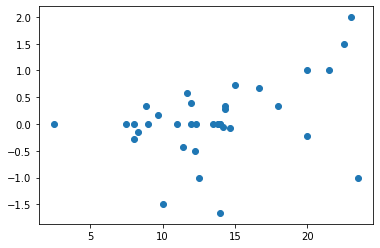

In [22]:
plt.scatter(stints['pace'],stints['Y'])

In [16]:
stints['AOF'] = stints['AOF'].apply(str)
TotalPM = stints[['AOF','chg']].groupby('AOF').sum().reset_index()
TotalPM.sort_values(by='chg')

,AOF,chg
6,"['BELL,THOMAS', 'JONES,RUBIN', 'MCBRIDE,MARDRE...",-3.0
4,"['BELL,THOMAS', 'JONES,RUBIN', 'LEWIS II,TEREN...",-2.0
0,"['BELL,THOMAS', 'HAMLET,JAVION', 'JONES,RUBIN'...",0.0
5,"['BELL,THOMAS', 'JONES,RUBIN', 'MCBRIDE,MARDRE...",0.0
9,"['HAMLET,JAVION', 'LEWIS II,TERENCE', 'MCBRIDE...",0.0
7,"['HAMLET,JAVION', 'JONES,RUBIN', 'LEWIS II,TER...",1.0
1,"['BELL,THOMAS', 'HAMLET,JAVION', 'JONES,RUBIN'...",2.0
2,"['BELL,THOMAS', 'HAMLET,JAVION', 'LEWIS II,TER...",2.0
10,"['JONES,RUBIN', 'MCBRIDE,MARDREZ', 'MURRAY,JJ'...",2.0
3,"['BELL,THOMAS', 'HAMLET,JAVION', 'MCBRIDE,MARD...",3.0


# 